**Introduction**

The following dataset shows a history of house sales in Ames, Iowa.

We want to be able to predict a house price based on the information in the given dataset.

In [1]:
#invite friends for the Kaggle party
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

Know your data - exploratory data analysis!

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

#starting with EDA
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [4]:
train.shape

(1460, 81)

In [5]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

There are a lot of columns to work with, let's check which do we need.

We'll begin by inspecting which columns correlate best with 'SalePrice'.

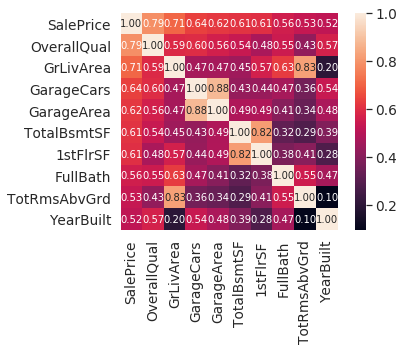

In [6]:
#SalePrice correlation matrix
correlations = train.corr()
cols = correlations.nlargest(10, 'SalePrice').index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show() #display heatmap

#take the 5 columns in which the correlation is highest.
correlations = correlations["SalePrice"].sort_values(ascending=False)
features = correlations.index[1:6]

**Handling Missing Data:**

For a dataset of this size, a lot of missing values can be found. In order to effectively train our model we build, we must first deal with the missing values. There are missing values for both numerical and categorical data. 

For numerical imputing, we would typically fill the missing values with a measure like median, mean, or mode.
For categorical imputing, we'll fill the missing values with the most common term that appeared from the entire column (one of many techniques). 

We can see in the data description file, that for some categories, NaN means something.
This means that if a value is NaN, the house might not have that certain attribute, which will affect the price of the house.
We will deal with it by filling the null cell with "None".

In [7]:
train_null = pd.isnull(train).sum() #number of null values for each column in the train set
test_null = pd.isnull(test).sum() #number of null values for each column in the test set

null = pd.concat([train_null, test_null], axis=1, keys=["Train", "Test"], sort='True')

In [8]:
null_many = null[null.sum(axis=1) > 200]  #many missing values
null_few = null[(null.sum(axis=1) > 0) & (null.sum(axis=1) < 200)]  #few much missing values

In [9]:
null_many

,Train,Test
Alley,1369,1352.0
Fence,1179,1169.0
FireplaceQu,690,730.0
LotFrontage,259,227.0
MiscFeature,1406,1408.0
PoolQC,1453,1456.0


For example, we can see that there are a lot of missing values in the 'Alley' column. A quick look at the description will show us that NaN in the 'Alley' column stands for no alley access.

In [10]:
#more can be found on the description data file provided

null_has_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [11]:
#change the null value to "None" where null means something
for null_value in null_has_meaning:
    train[null_value].fillna("None", inplace=True)
    test[null_value].fillna("None", inplace=True)

Dealing with the "real" NaN values:


In [12]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

We made some changes to null values, so let's update our dataframes:

In [13]:
train_null = pd.isnull(train).sum() #number of null values for each column in the train set
test_null = pd.isnull(test).sum() #number of null values for each column in the test set

null = pd.concat([train_null, test_null], axis=1, keys=["Train", "Test"], sort='True')

In [14]:
null_many = null[null.sum(axis=1) > 200]  #many missing values
null_few = null[(null.sum(axis=1) > 0) & (null.sum(axis=1) < 200)]  #few much missing values

In [15]:
null_many

,Train,Test
LotFrontage,259,227.0


It seems like 'LotFrontage' has too many null values and it is a numerical value so it may be better to drop it.

In [16]:
train.drop("LotFrontage", axis=1, inplace=True)
test.drop("LotFrontage", axis=1, inplace=True)

In [17]:
null_few

,Train,Test
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0
BsmtFullBath,0,2.0
BsmtHalfBath,0,2.0
BsmtUnfSF,0,1.0
Electrical,1,0.0
Exterior1st,0,1.0
Exterior2nd,0,1.0
Functional,0,2.0
GarageArea,0,1.0


GarageYrBlt, MasVnrArea, and MasVnrType all have a decent amount of missing values. MasVnrType is categorical so we can replace the missing values with "None", as we did before. We'll fill the others with median.

In [18]:
train["GarageYrBlt"].fillna(train["GarageYrBlt"].median(), inplace=True)
test["GarageYrBlt"].fillna(test["GarageYrBlt"].median(), inplace=True)
train["MasVnrArea"].fillna(train["MasVnrArea"].median(), inplace=True)
test["MasVnrArea"].fillna(test["MasVnrArea"].median(), inplace=True)
train["MasVnrType"].fillna("None", inplace=True)
test["MasVnrType"].fillna("None", inplace=True)

We took care of the features with a lot of missing values, now we'll take care of the ones with few missing values.

In [19]:
#split to numerical (type = int, float) and categorical (type = object) featues:

#train set
types_train = train.dtypes #type of each feature in data: int, float, object
num_train = types_train[(types_train == int) | (types_train == float)] 
cat_train = types_train[types_train == object] 

#test set
types_test = test.dtypes
num_test = types_test[(types_test == int) | (types_test == float)]
cat_test = types_test[types_test == object]

Numerical Imputing

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


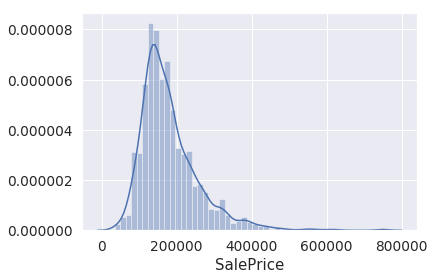

In [20]:
sns.distplot(train['SalePrice'])

We can see that our data is skewed right, so we'll impute with median.

In [21]:
#lists are easier to work with, so we'll convert num_train and num_test.
numerical_values_train = list(num_train.index)
numerical_values_test = list(num_test.index)

Those are all of the numerical features in our data:

In [22]:
print (numerical_values_train)

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [23]:
#create a list of all features with missing values
missing_num = []

for feature in numerical_values_train:
    if feature in list(null_few.index):
        missing_num.append(feature)

Those are all of the numerical features with missing data

In [24]:
print (missing_num)

['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [25]:
#impute
for feature in missing_num:
    train[feature].fillna(train[feature].median(), inplace=True)
    test[feature].fillna(test[feature].median(), inplace=True)

Categorical Imputing

Those are non-numerical features so we can't use a technique like median value on them. Instead we'll impute with the most common term that appears in the entire list.

In [26]:
categorical_values_train = list(cat_train.index)
categorical_values_test = list(cat_test.index)

All of the categorical features:

In [27]:
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [28]:
#create a list of all features with missing values
missing_cat = []

for feature in categorical_values_train:
    if feature in list(null_few.index):
        missing_cat.append(feature)

Those are all of the categorical features with missing data

In [29]:
print(missing_cat)

['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Electrical', 'KitchenQual', 'Functional', 'SaleType']


In [30]:
def most_common_term(lst):
    lst = list(lst)
    return max(set(lst), key=lst.count)
#most_common_term finds the most common term in a series

most_common = ["Electrical", "Exterior1st", "Exterior2nd", "Functional", "KitchenQual", "MSZoning", "SaleType", "Utilities", "MasVnrType"]

counter = 0
for i in missing_cat:
    most_common[counter] = most_common_term(train[i])
    counter += 1

Those are the categorical features with missing values

In [31]:
most_common_dictionary = {missing_cat[x]: [most_common[x]] for x in range(len(most_common))}
most_common_dictionary

{'MSZoning': ['RL'],
 'Utilities': ['AllPub'],
 'Exterior1st': ['VinylSd'],
 'Exterior2nd': ['VinylSd'],
 'MasVnrType': ['None'],
 'Electrical': ['SBrkr'],
 'KitchenQual': ['TA'],
 'Functional': ['Typ'],
 'SaleType': ['WD']}

In [32]:
#replace null values with most common term
counter = 0
for feature in missing_cat:  
    train[feature].fillna(most_common[counter], inplace=True)
    test[feature].fillna(most_common[counter], inplace=True)
    counter += 1

We took care of both the numerical features and the categorical featues, if all worked according to our plan we shouldn't have any null values left. Since we are being thorough, we will check if all is well.

In [33]:
#updating the null values series
train_null = pd.isnull(train).sum() #number of null values for each column in the train set
test_null = pd.isnull(test).sum() #number of null values for each column in the test set

null = pd.concat([train_null, test_null], axis=1, keys=["Train", "Test"], sort='True')
null[null.sum(axis=1) > 0] #all features with 1 or more null values

,Train,Test


An empty table, we did it!

**Feature Engineering**

We have dealt with all of the missing values, now it's time for the next step of our data preprocessing - feature engineering!
We need to create feature vectors in order to get the data ready for our model as training data. To do so, we will have to convert the categorical values into representative numbers.

As we saw earlier, out data is skewed right, so we'll use log transformation on it.

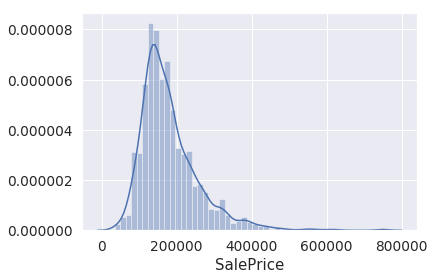

In [34]:
#before log transforamtion
sns.distplot(train['SalePrice'])

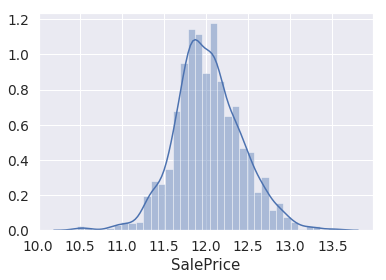

In [35]:
train["TransformedPrice"] = np.log(train["SalePrice"])

#after log transformation
sns.distplot(np.log(train["SalePrice"]))

Our target feature SalePrice used to be very skewed, but thanks to the logarithm transformation it is no more.
Now we can see that it is more normally distributed, which works better with machine learning models.

Now we'll look on the catergorical data that needs to be transformed

In [36]:
categorical_values_train = list(cat_train.index)
categorical_values_test = list(cat_test.index)

print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [37]:
#convert categorical values into representative numbers
#train set
for feature in categorical_values_train:
    feature_set = set(train[feature]) #unique values for the feature
    for cat_val in feature_set:
        feature_list = list(feature_set)
        train.loc[train[feature] == cat_val, feature] = feature_list.index(cat_val)
        
#test set
for feature in categorical_values_test:
    feature_set2 = set(test[feature]) #unique values for the feature
    for cat_val in feature_set2:
        feature_list2 = list(feature_set2)
        test.loc[test[feature] == cat_val, feature] = feature_list2.index(cat_val)

In [38]:
train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TransformedPrice
0,1,60,0,8450,0,1,1,2,0,3,0,12,0,0,2,3,7,5,2003,2003,5,6,2,2,1,196.0,2,2,4,2,1,4,2,706,3,0,150,856,4,0,...,2,856,854,0,1710,1,0,2,1,3,1,2,8,0,0,3,0,2003.0,3,2,548,2,2,1,0,61,0,0,0,0,1,2,3,0,2,2008,3,1,208500,12.247694
1,2,20,0,9600,0,1,1,2,0,4,0,15,1,0,2,0,6,8,1976,1976,5,6,7,9,2,0.0,1,2,2,2,1,1,6,978,3,0,284,1262,4,0,...,2,1262,0,0,1262,0,1,2,0,3,1,1,6,0,1,2,0,1976.0,3,2,460,2,2,1,298,0,0,0,0,0,1,2,3,0,5,2007,3,1,181500,12.109011
2,3,60,0,11250,0,1,3,2,0,3,0,12,0,0,2,3,7,5,2001,2002,5,6,2,2,1,162.0,2,2,4,2,1,0,2,486,3,0,434,920,4,0,...,2,920,866,0,1786,1,0,2,1,3,1,2,6,0,1,2,0,2001.0,3,2,608,2,2,1,0,42,0,0,0,0,1,2,3,0,9,2008,3,1,223500,12.317167
3,4,70,0,9550,0,1,3,2,0,1,0,18,0,0,2,3,7,5,1915,1970,5,6,1,0,2,0.0,1,2,1,1,2,4,6,216,3,0,540,756,4,3,...,2,961,756,0,1717,1,0,1,0,3,1,2,7,0,1,4,4,1998.0,1,3,642,2,2,1,0,35,272,0,0,0,1,2,3,0,2,2006,3,3,140000,11.849398
4,5,60,0,14260,0,1,3,2,0,4,0,21,0,0,2,3,8,5,2000,2000,5,6,2,2,1,350.0,2,2,4,2,1,3,2,655,3,0,490,1145,4,0,...,2,1145,1053,0,2198,1,0,2,1,4,1,2,9,0,1,2,0,2000.0,3,3,836,2,2,1,192,84,0,0,0,0,1,2,3,0,12,2008,3,1,250000,12.429216


In [39]:
test.head()

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,4,11622,0,1,1,2,0,3,0,8,1,0,2,0,5,6,1961,1961,5,3,2,3,2,0.0,1,2,2,1,1,4,0,468.0,1,144.0,270.0,882.0,1,2,1,0,896,0,0,896,0.0,0.0,1,0,2,1,1,5,0,0,3,0,1961.0,1,1.0,730.0,1,2,1,140,0,0,0,120,0,1,1,1,0,6,2010,3,2
1,1462,20,0,14267,0,1,3,2,0,1,0,8,0,0,2,0,6,6,1958,1958,1,3,1,2,1,108.0,1,2,2,1,1,4,6,923.0,3,0.0,406.0,1329.0,1,2,1,0,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,0,0,3,0,1958.0,1,1.0,312.0,1,2,1,393,36,0,0,0,0,1,2,0,12500,6,2010,3,2
2,1463,60,0,13830,0,1,3,2,0,3,0,11,0,0,2,3,5,5,1997,1998,5,3,2,3,2,0.0,1,2,4,2,1,4,2,791.0,3,0.0,137.0,928.0,1,3,1,0,928,701,0,1629,0.0,0.0,2,1,3,1,1,6,0,1,2,0,1997.0,0,2.0,482.0,1,2,1,212,34,0,0,0,0,1,1,1,0,3,2010,3,2
3,1464,60,0,9978,0,1,3,2,0,3,0,11,0,0,2,3,6,6,1998,1998,5,3,2,3,1,20.0,1,2,4,1,1,4,2,602.0,3,0.0,324.0,926.0,1,0,1,0,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,0,1,4,0,1998.0,0,2.0,470.0,1,2,1,360,36,0,0,0,0,1,2,1,0,6,2010,3,2
4,1465,120,0,5005,0,1,3,0,0,3,0,5,0,0,3,0,8,5,1992,1992,5,3,7,10,2,0.0,2,2,4,2,1,4,6,263.0,3,0.0,1017.0,1280.0,1,0,1,0,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,0,0,3,0,1992.0,3,2.0,506.0,1,2,1,0,82,0,0,144,0,1,2,1,0,1,2010,3,2


Looks like we have changed all the categorical strings into a representative number. Now we can move on to the next step.


**Creating, Training, Evaluating, Validating, and Testing ML Models**

We've finished the preprocessing part. Now we know and understand our data much better!
We can start to build and test different models for regression to predit the sale price of each house.
We'll import the models, train them and evaluate them. We'll use the R^2 score and the RMSE to  evaluate our model performance.
We will also use cross validation to optimize our model hyperparameters.

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Defining Training/Test Sets**

We drop the Id and SalePrice columns for the training set since those are not involved in predicting the Sale Price of a house. The SalePrice column will become our training target. Remember how we transformed SalePrice to make the distribution more normal? Well we can apply that here and make TransformedPrice the target instead of SalePrice. This will improve model performance and yield a much smaller RMSE because of the scale.

In [41]:
X_train = train.drop(["Id", "SalePrice", "TransformedPrice"], axis=1).values
y_train = train["TransformedPrice"].values
X_test = test.drop("Id", axis=1).values

**Splitting into Validation**

It is always good to split our training data again into validation sets. This will help us evaluate our model performance as well as avoid overfitting our model.

In [42]:
from sklearn.model_selection import train_test_split #to create validation data set

X_training, X_valid, y_training, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0) #X_valid and y_valid are the validation sets

**Linear Regression Model**

In [43]:
linreg = LinearRegression()
parameters_lin = {"fit_intercept" : [True, False], "normalize" : [True, False], "copy_X" : [True, False]}
grid_linreg = GridSearchCV(linreg, parameters_lin, verbose=1 , scoring = "r2")
grid_linreg.fit(X_training, y_training)

print("Best Linear Regression Model: " + str(grid_linreg.best_estimator_))
print("Best Score: " + str(grid_linreg.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Linear Regression Model: LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)
Best Score: 0.8744420132600108


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.3s finished


In [44]:
linreg = grid_linreg.best_estimator_
linreg.fit(X_training, y_training)
lin_pred = linreg.predict(X_valid)
r2_lin = r2_score(y_valid, lin_pred)
rmse_lin = np.sqrt(mean_squared_error(y_valid, lin_pred))
print("R^2 Score: " + str(r2_lin))
print("RMSE Score: " + str(rmse_lin))

R^2 Score: 0.7114184534361392
RMSE Score: 0.20902440173565368


In [45]:
scores_lin = cross_val_score(linreg, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_lin)))

Cross Validation Score: 0.8779444778221869


**Decision Tree Regressor Model**

In [46]:
dtr = DecisionTreeRegressor()
parameters_dtr = {"criterion" : ["mse", "friedman_mse", "mae"], "splitter" : ["best", "random"], "min_samples_split" : [2, 3, 5, 10], 
                  "max_features" : ["auto", "log2"]}
grid_dtr = GridSearchCV(dtr, parameters_dtr, verbose=1, scoring="r2")
grid_dtr.fit(X_training, y_training)

print("Best DecisionTreeRegressor Model: " + str(grid_dtr.best_estimator_))
print("Best Score: " + str(grid_dtr.best_score_))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best DecisionTreeRegressor Model: DecisionTreeRegressor(criterion='friedman_mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')
Best Score: 0.7360201922014465


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:    5.1s finished


In [47]:
dtr = grid_dtr.best_estimator_
dtr.fit(X_training, y_training)
dtr_pred = dtr.predict(X_valid)
r2_dtr = r2_score(y_valid, dtr_pred)
rmse_dtr = np.sqrt(mean_squared_error(y_valid, dtr_pred))
print("R^2 Score: " + str(r2_dtr))
print("RMSE Score: " + str(rmse_dtr))

R^2 Score: 0.752466495838067
RMSE Score: 0.1935885673059534


In [48]:
scores_dtr = cross_val_score(dtr, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_dtr)))

Cross Validation Score: 0.7052740413926688


**Random Forest Regressor**

In [49]:
rf = RandomForestRegressor()
paremeters_rf = {"n_estimators" : [5, 10, 15, 20], "criterion" : ["mse" , "mae"], "min_samples_split" : [2, 3, 5, 10], 
                 "max_features" : ["auto", "log2"]}
grid_rf = GridSearchCV(rf, paremeters_rf, verbose=1, scoring="r2")
grid_rf.fit(X_training, y_training)

print("Best RandomForestRegressor Model: " + str(grid_rf.best_estimator_))
print("Best Score: " + str(grid_rf.best_score_))

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Best RandomForestRegressor Model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Best Score: 0.8601231714957425


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.3min finished


In [52]:
rf = grid_rf.best_estimator_
rf.fit(X_training, y_training)
rf_pred = rf.predict(X_valid)
r2_rf = r2_score(y_valid, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_valid, rf_pred))
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))

R^2 Score: 0.8559075781752148
RMSE Score: 0.1477009474621756


In [53]:
scores_rf = cross_val_score(rf, X_training, y_training, cv=10, scoring="r2")
print("Cross Validation Score: " + str(np.mean(scores_rf)))

Cross Validation Score: 0.8590186306089962


**Evaluation Our Models**

We have built and trained a few different regression models, now we'll compare them to see which one is best and should be used to predict on the test test.

In [56]:
model_performances = pd.DataFrame({
    "Model" : ["Linear Regression", "Decision Tree Regressor", "Random Forest Regressor"],
    "Best Score" : [grid_linreg.best_score_, grid_dtr.best_score_, grid_rf.best_score_],
    "R Squared" : [str(r2_lin)[0:5], str(r2_dtr)[0:5], str(r2_rf)[0:5]],
    "RMSE" : [str(rmse_lin)[0:8], str(rmse_dtr)[0:8], str(rmse_rf)[0:8]]
})

model_performances.round(4)

print("Sorted by Best Score:")
model_performances.sort_values(by="Best Score", ascending=False)

Sorted by Best Score:


,Model,Best Score,R Squared,RMSE
0,Linear Regression,0.874442,0.711,0.209024
2,Random Forest Regressor,0.860123,0.855,0.147700
1,Decision Tree Regressor,0.736020,0.752,0.193588


In [65]:
print("Sorted by R Squared:")
model_performances.sort_values(by="R Squared", ascending=False)

Sorted by R Squared:


,Model,Best Score,R Squared,RMSE
2,Random Forest Regressor,0.860123,0.855,0.147700
1,Decision Tree Regressor,0.736020,0.752,0.193588
0,Linear Regression,0.874442,0.711,0.209024


In [66]:
print("Sorted by RMSE:")
model_performances.sort_values(by="RMSE", ascending=True)

Sorted by RMSE:


,Model,Best Score,R Squared,RMSE
2,Random Forest Regressor,0.860123,0.855,0.147700
1,Decision Tree Regressor,0.736020,0.752,0.193588
0,Linear Regression,0.874442,0.711,0.209024


The RMSEs are small because of the log transformation we performed. So even a 0.1 RMSE may be significant in this case.

I chose to use Random Forest Regressor because it ranked first on 2 of our 3 measurements.
It has a low RMSE and a high R^2.

In [67]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [68]:
final_predictions = np.exp(rf.predict(X_test))

In [71]:
results = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": final_predictions
    })

print(results.shape)

(1459, 2)


In [73]:
results.head(10)

,Id,SalePrice
0,1461,125971.779476
1,1462,157017.488253
2,1463,168426.399809
3,1464,208868.713918
4,1465,176834.384424
5,1466,196824.640202
6,1467,169242.191740
7,1468,175351.270525
8,1469,186593.337109
9,1470,140957.780490
